In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
import os
import geopandas as gpd
from langchain_experimental.agents.agent_toolkits import (
    create_pandas_dataframe_agent,
)
from langchain_openai import OpenAI as OpenAI_langchain


client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)


df_community = pd.read_parquet("all_poster_commenter_details.parquet")
df_issues = pd.read_parquet("issue_details_with_posters_small.parquet")

In [4]:
df_issues

,body,comments,commenters,createdAt,labels,milestone,projectCards,reactionGroups,n_body_reactions_thumbs_up,n_body_reactions_thumbs_down,...,location_lat,location_lon,email,hireable,bio,twitter_username,followers,following,created_at,updated_at
0,I use Linux at work but at home I have windows...,[{'id': 'MDEyOklzc3VlQ29tbWVudDMxNDEzOTU1MQ=='...,"['SteffenRoe', 'marcodelmoral', 'beckernick', ...",2017-07-01T05:54:03Z,"[{'id': 'MDU6TGFiZWw1OTk2MjY1NjE=', 'name': 'f...",NaN,"[{'project': {'name': 'Feature Planning'}, 'co...","[{'content': 'THUMBS_UP', 'users': {'totalCoun...",43,0,...,44.933143,7.540121,None,True,None,None,6.0,8.0,2010-06-04T18:44:57Z,2024-03-11T00:13:42Z
1,<!--\r\n\r\nThanks for opening an issue! To he...,[{'id': 'MDEyOklzc3VlQ29tbWVudDQzMzI1NzI1NQ=='...,"['harrism', 'hcho3', 'beckernick', 'vyasr', 'P...",2018-09-09T17:57:58Z,"[{'id': 'MDU6TGFiZWwxMTM5NzUwMDA1', 'name': 'C...",NaN,"[{'project': {'name': 'Other Issues'}, 'column...",[],0,0,...,44.977300,-93.265469,None,None,@NVIDIA Lead for CUDA C++ Core Libraries (CCCL...,None,156.0,0.0,2015-10-20T21:24:04Z,2024-05-07T21:51:10Z
2,<!--\r\n\r\nThanks for opening an issue! To he...,[{'id': 'MDEyOklzc3VlQ29tbWVudDQ0OTE1NTg1Mw=='...,"['harrism', 'GregoryKimball', 'vyasr', 'teju85...",2018-08-29T18:00:18Z,"[{'id': 'MDU6TGFiZWw1OTk2MjY1NjE=', 'name': 'f...",NaN,[],[],0,0,...,43.111673,-88.499266,dev@aas.io,None,None,None,66.0,12.0,2012-02-07T15:29:08Z,2024-05-28T01:02:01Z
3,**Describe the bug**\r\n\r\nIt takes a few sec...,[{'id': 'MDEyOklzc3VlQ29tbWVudDQ2NjU0OTA3Ng=='...,"['harrism', 'lmeyerov', 'shwina', 'GregoryKimb...",2019-01-04T02:46:53Z,"[{'id': 'MDU6TGFiZWw1OTk2MjY1NjE=', 'name': 'f...",NaN,"[{'project': {'name': 'Feature Planning'}, 'co...",[],0,0,...,30.271129,-97.743700,None,True,None,mrocklin,1778.0,0.0,2010-06-16T02:36:34Z,2024-05-25T14:10:06Z
4,This corresponds to 'escapechar' parameter in ...,[{'id': 'MDEyOklzc3VlQ29tbWVudDQ1OTUwMzk2NA=='...,"['OlivierNV', 'harrism', 'mjsamoht']",2019-01-16T23:00:29Z,"[{'id': 'MDU6TGFiZWw1OTk2MjY1NjE=', 'name': 'f...",NaN,"[{'project': {'name': 'Feature Planning'}, 'co...",[],0,0,...,37.233325,-121.684635,None,None,None,None,1.0,0.0,2018-10-25T18:04:07Z,2023-04-24T19:08:34Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,For the overload of replace in libcudf where i...,"[{'id': 'IC_kwDOBWUGps5-9OuK', 'author': {'log...","['lithomas1', 'davidwendt']",2024-05-24T16:46:09Z,"[{'id': 'MDU6TGFiZWw1OTk2MjY1NjE=', 'name': 'f...",NaN,[],[],0,0,...,38.980666,-76.936919,None,None,CS @ UMD,None,42.0,29.0,2019-02-25T05:11:14Z,2024-05-21T13:33:04Z
871,Reproducible code:\r\n```\r\nusing f_wrapper =...,[],[],2024-05-24T20:58:21Z,"[{'id': 'MDU6TGFiZWw1OTk2MjY1NTk=', 'name': 'b...",NaN,[],[],0,0,...,39.783730,-100.445882,None,None,A computer and food enthusiast.,nghiatruong_vn,109.0,93.0,2014-04-26T23:14:06Z,2024-05-28T05:31:11Z
872,**Is your feature request related to a problem...,[],[],2024-05-24T23:51:20Z,"[{'id': 'MDU6TGFiZWw1OTk2MjY1NjE=', 'name': 'f...",NaN,[],[],0,0,...,44.933143,7.540121,None,None,None,None,134.0,0.0,2015-01-22T03:44:35Z,2023-11-18T04:46:15Z
873,"Currently, when converting floating point type...",[],[],2024-05-29T21:36:01Z,"[{'id': 'MDU6TGFiZWw1OTk2MjY1NTk=', 'name': 'b...",NaN,[],[],0,0,...,39.783730,-100.445882,None,None,A computer and food enthusiast.,nghiatruong_vn,109.0,93.0,2014-04-26T23:14:06Z,2024-05-28T05:31:11Z


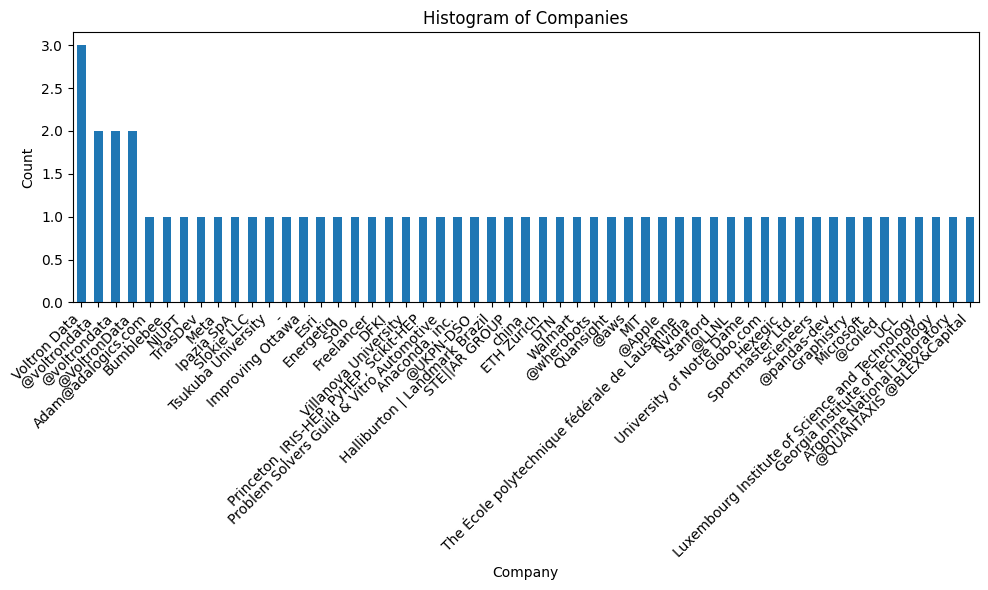

In [23]:
external_users = df[df["is_nvidia_employee"] == False]
company_counts = external_users['company'].value_counts()

# Plotting the histogram
plt.figure(figsize=(10,6))
company_counts.plot(kind='bar')
plt.title('Histogram of Companies')
plt.xlabel('Company')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [24]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What type of company is Walmart?",
        }
    ],
    model="gpt-3.5-turbo",
)
chat_completion.choices[0].message.content

"Walmart is a multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores. It is the world's largest company by revenue and one of the largest employers globally."

In [25]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What type of company is Halliburton?",
        }
    ],
    model="gpt-3.5-turbo",
)
chat_completion.choices[0].message.content

"Halliburton is an American multinational corporation that provides a variety of products and services to the energy industry, primarily oil and gas exploration and production. They are one of the world's largest oilfield services companies."

In [26]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["location_lon"], df["location_lat"]),
    crs="epsg:4326",
)

In [30]:
gdf[["login", "name", "followers", "company", "is_nvidia_employee", "geometry"]].explore(column="is_nvidia_employee", cmap="viridis")

In [31]:
df = pd.read_parquet("issue_details_with_posters_small.parquet")

In [45]:
df

,login,id,node_id,avatar_url,gravatar_id,url,html_url,followers_url,following_url,gists_url,starred_url,subscriptions_url,organizations_url,repos_url,events_url,received_events_url,type,site_admin,name,company,blog,location,email,hireable,bio,twitter_username,public_repos,public_gists,followers,following,created_at,updated_at,message,documentation_url,location_lat,location_lon,is_nvidia_employee
0,AdamKorcz,44787359.0,MDQ6VXNlcjQ0Nzg3MzU5,https://avatars.githubusercontent.com/u/447873...,,https://api.github.com/users/AdamKorcz,https://github.com/AdamKorcz,https://api.github.com/users/AdamKorcz/followers,https://api.github.com/users/AdamKorcz/followi...,https://api.github.com/users/AdamKorcz/gists{/...,https://api.github.com/users/AdamKorcz/starred...,https://api.github.com/users/AdamKorcz/subscri...,https://api.github.com/users/AdamKorcz/orgs,https://api.github.com/users/AdamKorcz/repos,https://api.github.com/users/AdamKorcz/events{...,https://api.github.com/users/AdamKorcz/receive...,User,False,None,Adam@adalogics.com,https://adalogics.com,None,None,None,Security & open-source at ADA Logics,None,238.0,0.0,38.0,1.0,2018-11-05T20:50:32Z,2024-05-18T15:35:10Z,None,None,44.933143,7.540121,False
1,AjayThorve,20476096.0,MDQ6VXNlcjIwNDc2MDk2,https://avatars.githubusercontent.com/u/204760...,,https://api.github.com/users/AjayThorve,https://github.com/AjayThorve,https://api.github.com/users/AjayThorve/followers,https://api.github.com/users/AjayThorve/follow...,https://api.github.com/users/AjayThorve/gists{...,https://api.github.com/users/AjayThorve/starre...,https://api.github.com/users/AjayThorve/subscr...,https://api.github.com/users/AjayThorve/orgs,https://api.github.com/users/AjayThorve/repos,https://api.github.com/users/AjayThorve/events...,https://api.github.com/users/AjayThorve/receiv...,User,False,Ajay Thorve,Nvidia,,Washington,None,True,"software dev at RAPIDSAI, Nvidia",AjayTh123,78.0,8.0,29.0,6.0,2016-07-15T11:57:43Z,2024-05-27T04:09:08Z,None,None,38.895037,-77.036543,True
2,BassemKaroui,23449512.0,MDQ6VXNlcjIzNDQ5NTEy,https://avatars.githubusercontent.com/u/234495...,,https://api.github.com/users/BassemKaroui,https://github.com/BassemKaroui,https://api.github.com/users/BassemKaroui/foll...,https://api.github.com/users/BassemKaroui/foll...,https://api.github.com/users/BassemKaroui/gist...,https://api.github.com/users/BassemKaroui/star...,https://api.github.com/users/BassemKaroui/subs...,https://api.github.com/users/BassemKaroui/orgs,https://api.github.com/users/BassemKaroui/repos,https://api.github.com/users/BassemKaroui/even...,https://api.github.com/users/BassemKaroui/rece...,User,False,Bassem Karoui,None,,"Massy, France",bassem.karoui1@gmail.com,True,None,None,11.0,0.0,0.0,0.0,2016-11-14T09:18:15Z,2024-05-19T10:15:23Z,None,None,49.690211,1.399492,False
3,ChrisJar,13131098.0,MDQ6VXNlcjEzMTMxMDk4,https://avatars.githubusercontent.com/u/131310...,,https://api.github.com/users/ChrisJar,https://github.com/ChrisJar,https://api.github.com/users/ChrisJar/followers,https://api.github.com/users/ChrisJar/followin...,https://api.github.com/users/ChrisJar/gists{/g...,https://api.github.com/users/ChrisJar/starred{...,https://api.github.com/users/ChrisJar/subscrip...,https://api.github.com/users/ChrisJar/orgs,https://api.github.com/users/ChrisJar/repos,https://api.github.com/users/ChrisJar/events{/...,https://api.github.com/users/ChrisJar/received...,User,False,None,None,,None,cjarrett@nvidia.com,None,None,None,24.0,0.0,0.0,0.0,2015-07-01T07:21:00Z,2024-03-21T18:35:54Z,None,None,44.933143,7.540121,False
4,FilippoSimini,22484769.0,MDQ6VXNlcjIyNDg0NzY5,https://avatars.githubusercontent.com/u/224847...,,https://api.github.com/users/FilippoSimini,https://github.com/FilippoSimini,https://api.github.com/users/FilippoSimini/fol...,https://api.github.com/users/FilippoSimini/fol...,https://api.github.com/users/FilippoSimini/gis...,https://api.github.com/users/FilippoSimini/sta...,https://api.github.com/users/FilippoSimini/sub...,https://api.gith

In [36]:
df[df["company"] == "Walmart"]["body"].values[0]

"having predicate pushdowns such as bloom filters work as in hive to skip over sections of data on disk during the read would enable better overall performance as the data would never have to be loaded to memory and then discarded if the predicate didn't match in the row group.\r\n\r\nsupport predicate pushdown similar to what is done with hive in read_orc, primary support for bloom filter but also for sorted data as well to enable only loading relevant data to query.\r\n\r\n\r\n"

In [40]:
content = (
    "Can you summarize this GitHub issue in the cudf repo? "
    f"{df[df['company'] == 'Walmart']['body'].values[0]}"
)
content

"Can you summarize this GitHub issue in the cudf repo? having predicate pushdowns such as bloom filters work as in hive to skip over sections of data on disk during the read would enable better overall performance as the data would never have to be loaded to memory and then discarded if the predicate didn't match in the row group.\r\n\r\nsupport predicate pushdown similar to what is done with hive in read_orc, primary support for bloom filter but also for sorted data as well to enable only loading relevant data to query.\r\n\r\n\r\n"

In [41]:
content = (
    "Can you summarize this GitHub issue in the cudf repo? "
    f"{df[df['company'] == 'Walmart']['body'].values[0]}"
)
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": content
        }
    ],
    model="gpt-3.5-turbo",
)
chat_completion.choices[0].message.content

'This GitHub issue in the cudf repo is discussing the implementation of predicate pushdowns, specifically using bloom filters, to improve performance during data reads. By allowing the system to skip over sections of data on disk that do not match the predicate, unnecessary loading of data into memory can be avoided, leading to better overall performance. The primary focus is on supporting bloom filters, but also considering support for sorted data to efficiently load only relevant data for queries.'

In [43]:
agent = create_pandas_dataframe_agent(OpenAI_langchain(temperature=0), df, verbose=True)

In [44]:
agent.invoke("how many rows are there?")["output"]



> Entering new AgentExecutor chain...
Thought: I need to count the number of rows in the dataframe.
Action: python_repl_ast
Action Input: len(df)248248 rows is the number of rows in the dataframe.
Final Answer: There are 248 rows in the dataframe.

> Finished chain.


'There are 248 rows in the dataframe.'